# Centro de Investigación en Matemáticas
# Inteligencia Artificial
## Tarea 2. Autoencoder
### José Miguel Saavedra Aguilar

In [47]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

np.random.seed(140324)

Haremos un autoencoder con una red de dos capas, esto es:

\begin{equation}
    \begin{aligned}
        y_0 &= x\\
        z_1 &= W_1 y_0 + b_1\\
        y_1 &= \phi_1(z_1)\\
        z_2 &= W_2 y_1 + b_2\\
        y_2 &= \phi_2(z_2)\\
        z_3 &= W_3 y_2 + b_3\\
        \hat{x} &= \phi_3(z_3)\\
    \end{aligned}
\end{equation}

Considerando la función de costo MSE:

\begin{align}
    \frac{1}{2}\| x-\hat{x} \|_2
\end{align}

Utilizaremos la función de activación sigmoide

\begin{align*}
    \phi(x) &= \frac{1}{1 + e^{-x}}
\end{align*}

cuya derivada es

\begin{align*}
    \phi^{\prime}(x) &= \phi(x) \left(1-\phi(x)\right)
\end{align*}

para las tres funciones de activación.

Para la backpropagation, haremos derivación paso a paso para cada observación de $x_i$:

\begin{align*}
    y_0 &= x\\
    z_1 &= W_1 y_0 + b_1\\
    y_1 &= \phi_1(z_1)\\
    z_2 &= W_2 y_1 + b_2\\
    y_2 &= \phi_2(z_2)\\
    z_3 &= W_3 y_2 + b_3\\
    \frac{\partial L}{\partial y_3} &= y_3 - x\\
    \frac{\partial y_3}{\partial z_3} &= \phi(z_3) (1-\phi(z_3))\\
    \frac{\partial z_3}{\partial W_3} &= y_2\\
    \frac{\partial z_3}{\partial b_3} &= 1\\
    \frac{\partial y_2}{\partial z_2} &= \phi(z_2) (1-\phi(z_2))\\
    \frac{\partial z_2}{\partial W_2} &= y_1\\
    \frac{\partial z_2}{\partial b_2} &= 1\\
    \frac{\partial y_1}{\partial z_1} &= \phi(z_1) (1-\phi(z_1))\\
    \frac{\partial z_1}{\partial W_1} &= y_0\\
    \frac{\partial z_1}{\partial b_1} &= 1
\end{align*}

De forma que:

\begin{align*}
    \frac{\partial L}{\partial W_3} &= \frac{\partial y_3}{\partial z_3} \frac{\partial z_3}{\partial W_3} &
    \frac{\partial L}{\partial W_2} &= \frac{\partial y_2}{\partial z_2} \frac{\partial z_2}{\partial W_2} &
    \frac{\partial L}{\partial W_1} &= \frac{\partial y_1}{\partial z_1} \frac{\partial z_1}{\partial W_1} \\
    \frac{\partial L}{\partial b_3} &= \frac{\partial y_3}{\partial z_3} \frac{\partial z_3}{\partial b_3} &
    \frac{\partial L}{\partial b_2} &= \frac{\partial y_2}{\partial z_2} \frac{\partial z_2}{\partial b_2} &
    \frac{\partial L}{\partial b_1} &= \frac{\partial y_1}{\partial z_1} \frac{\partial z_1}{\partial b_1}
\end{align*}

De forma que, definiendo $\delta_1, \delta_2, \delta_3$ como:
\begin{align*}
    \delta_3 &= (y_3 - X) * y_3 * (1-y_3) &
    \delta_2 &= W_3^{\top}\delta_3 * y_2 * (1-y_2) &
    \delta_1 &= W_2^{\top}\delta_2 * y_1 * (1-y_1)\\
    \frac{\partial L}{\partial W_3} &= \delta_3 y_2^{\top} &
    \frac{\partial L}{\partial W_2} &= \delta_2 y_1^{\top} &
    \frac{\partial L}{\partial W_1} &= \delta_1 y_0^{\top}\\
    \frac{\partial L}{\partial b_3} &= \delta_3 \mathbf{1}&
    \frac{\partial L}{\partial b_2} &= \delta_2 \mathbf{1}&
    \frac{\partial L}{\partial b_1} &= \delta_3 \mathbf{1}
\end{align*}



Inicializamos la red. Se creo como clase para poder correr el entrenamiento varias veces de ser necesario.

Se inician los pesos aleatorios distribuidos normales con media $\mu = 0$ y desviación estándar $\sigma = 0.1$. El tamaño de paso inicial es $10^{-5}$ pues en los puntos iniciales, el gradiente puede movernos en exceso. Para calcular el gradiente, tomamos submuestras $X_{batch}$ de $X$. Además, mientras avanzan las épocas, disminuimos el tamaño de paso, hasta llegar a $10^{-4}$.

In [48]:
class NeuralNetwork:
    def __init__(self,input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.learning_rate = 1e-5
        # Initialize weights and biases for the first hidden layer
        self.W1 = 0.1*np.random.randn(hidden_size1, input_size)
        self.b1 = np.zeros((hidden_size1, 1))
        
        # Initialize weights and biases for the second hidden layer
        self.W2 = 0.1*np.random.randn(hidden_size2, hidden_size1)
        self.b2 = np.zeros((hidden_size2, 1))
        
        # Initialize weights and biases for the output layer
        self.W3 = 0.1*np.random.randn(output_size, hidden_size2)
        self.b3 = np.zeros((output_size, 1))
        
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

    def sigmoid_derivative(self, X):
        return X * (1 - X)
    
    def forward(self, X):
        # Forward pass through the first hidden layer
        self.z1 = self.W1 @ X + self.b1
        self.y1 = self.sigmoid(self.z1)
        
        # Forward pass through the second hidden layer
        self.z2 = self.W2 @ self.y1 + self.b2
        self.y2 = self.sigmoid(self.z2)
        
        # Forward pass through the output layer
        self.z3 = self.W3 @ self.y2 + self.b3
        self.y3 = self.sigmoid(self.z3)
    
    def backward(self, X):
        # Backpropagation through the output layer
        self.delta3 = (self.y3 - X) * self.sigmoid_derivative(self.y3)
        
        # Backpropagation through the second hidden layer
        self.delta2 = np.dot(self.W3.T, self.delta3) * self.sigmoid_derivative(self.y2)
        
        # Backpropagation through the first hidden layer
        self.delta1 = np.dot(self.W2.T, self.delta2) * self.sigmoid_derivative(self.y1)
        
        # Calculate gradients
        self.W3_grad =  np.dot(self.delta3, self.y2.T)
        self.b3_grad = np.sum(self.delta3, axis=1, keepdims=True)
        
        self.W2_grad = np.dot(self.delta2, self.y1.T)
        self.b2_grad = np.sum(self.delta2, axis=1, keepdims=True)
        
        self.W1_grad = np.dot(self.delta1, X.T)
        self.b1_grad = np.sum(self.delta1, axis=1, keepdims=True)
        
        self.W1 -= self.learning_rate * self.W1_grad
        self.b1 -= self.learning_rate * self.b1_grad
        
        self.W2 -= self.learning_rate * self.W2_grad
        self.b2 -= self.learning_rate * self.b2_grad
        
        self.W3 -= self.learning_rate * self.W3_grad
        self.b3 -= self.learning_rate * self.b3_grad
    
    def loss(self, X):
        return np.mean(np.square(X - self.y3))
        
    def train(self, X, epochs, batch_size, learning_rate=1e-3):
        num_samples = X.shape[1]
        
        self.forward(X)
        self.backward(X)
        self.learning_rate = learning_rate
        stages = epochs // 100
        self.losses = np.zeros(100)
        print(f"Running {epochs} epochs with batch size {batch_size}.")
        print(f"Results will be printed every {stages} epochs.")
        print(f"Initial Loss: {self.loss(X):.4f}")
        print(f"Network Size: {self.input_size} -> {self.hidden_size1} -> {self.hidden_size2} -> {self.output_size}")
        print("Training...")
        for i in range(100):
            for j in range(stages-1):
                subsample = np.random.choice(num_samples, batch_size, replace=False)
                x_batch = X[:, subsample]
                self.forward(x_batch)
                self.backward(x_batch)
            self.learning_rate = max(2e-4, self.learning_rate * 0.5)
            self.forward(X)
            self.backward(X)
            self.losses[i] = self.loss(X)
            print(f"Epoch {stages * (i+1)}/{100*stages}, Loss: {self.losses[i]:.4f}")

Cargamos el dataset de MNIST, convertimos a un numpy array, y normalizamos.

In [49]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, cache=True)
X = mnist['data']
X = X.astype(np.float32)

# Normalize the input data
X /= 255.0

# Convert X and y to numpy arrays
X = np.array(X).T

Autoencoder con 3 capas ocultas. Datos de entrada tamaño 784, la primera capa de tamaño 128, la segunda de tamaño 32, la de salida de tamaño 784. Batches de tamaño 256. Tamaño de paso inicial $10^{-3}$.

In [50]:
# Set up neural network parameters
input_size = X.shape[0]
hidden_size1 = 128
hidden_size2 = 32
output_size = input_size  # Output size is same as input size for autoencoder
batch_size = 256
learning_rate = 1e-3
epochs = 20000

Creamos el modelo.

In [51]:
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

Entrenamos el modelo con el conjunto de datos MNIST.

In [52]:
model.train(X, epochs, batch_size, learning_rate)

Running 20000 epochs with batch size 256.
Results will be printed every 200 epochs.
Initial Loss: 0.2359
Network Size: 784 -> 128 -> 32 -> 784
Training...
Epoch 200/20000, Loss: 0.0671
Epoch 400/20000, Loss: 0.0622
Epoch 600/20000, Loss: 0.0567
Epoch 800/20000, Loss: 0.0524
Epoch 1000/20000, Loss: 0.0494
Epoch 1200/20000, Loss: 0.0476
Epoch 1400/20000, Loss: 0.0457
Epoch 1600/20000, Loss: 0.0438
Epoch 1800/20000, Loss: 0.0425
Epoch 2000/20000, Loss: 0.0413
Epoch 2200/20000, Loss: 0.0403
Epoch 2400/20000, Loss: 0.0392
Epoch 2600/20000, Loss: 0.0381
Epoch 2800/20000, Loss: 0.0370
Epoch 3000/20000, Loss: 0.0360
Epoch 3200/20000, Loss: 0.0351
Epoch 3400/20000, Loss: 0.0343
Epoch 3600/20000, Loss: 0.0335
Epoch 3800/20000, Loss: 0.0329
Epoch 4000/20000, Loss: 0.0323
Epoch 4200/20000, Loss: 0.0317
Epoch 4400/20000, Loss: 0.0312
Epoch 4600/20000, Loss: 0.0308
Epoch 4800/20000, Loss: 0.0303
Epoch 5000/20000, Loss: 0.0299
Epoch 5200/20000, Loss: 0.0295
Epoch 5400/20000, Loss: 0.0290
Epoch 5600/2

A continuación, mostramos una gráfica de cómo evoluciona la función de pérdida conforme evoluciona el modelo.

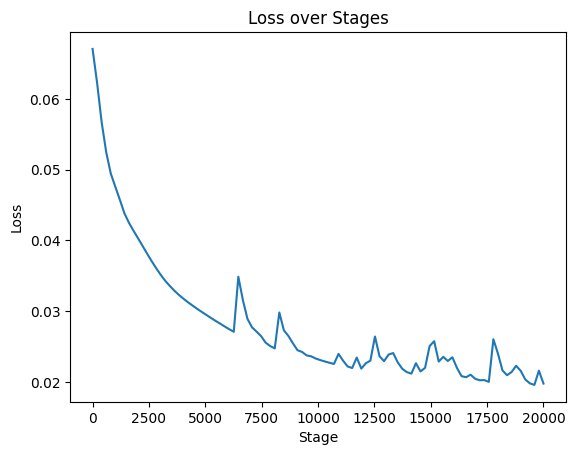

In [53]:
plt.plot(np.linspace(0,epochs, 100),model.losses)
plt.xlabel('Stage')
plt.ylabel('Loss')
plt.title('Loss over Stages')
plt.show()
